In [5]:
!pip install rdkit-pypi catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
os.chdir("/content/drive/MyDrive/2. TRAINING")

In [84]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.utils.data import TensorDataset

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# **1. Regression**

## 1.1. Data preparation

In [85]:
# Load data
df = pd.read_csv("Data/CHEMBL25_activities_EGFR.csv", index_col=0)
df = df.reset_index(drop=True)

# Keep necessary columns
chembl_df = df[["canonical_smiles", "pIC50"]]
chembl_df.head()

def smiles_to_fp(smiles, method="morgan2", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

chembl_df["fingerprints_df"] = chembl_df["canonical_smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe:", chembl_df.shape)
chembl_df.head(3)
# NBVAL_CHECK_OUTPUT
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50"]], test_size=0.2, random_state=42
)
X_train = np.array(list((x_train))).astype(float)

X_test = np.array(list((x_test))).astype(float)
# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

Shape of dataframe: (3906, 3)
Shape of training data: (3124,)
Shape of test data: (782,)


<ipython-input-85-b28e87d1a8b3>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chembl_df["fingerprints_df"] = chembl_df["canonical_smiles"].apply(smiles_to_fp)


In [86]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2,
                                                                random_state =42)

## 1.2. Baseline

In [87]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(loss_function="RMSE",
                           eval_metric=None,
                           task_type="GPU",
                           learning_rate=0.01,
                           iterations=10000,
                           l2_leaf_reg=50,
                           random_seed=42,
                           od_type="Iter",
                           depth=5,
                           early_stopping_rounds=100,
                           border_count=64
                           #has_time= True 
                          )
model.fit(X_train, y_train, verbose = 0)

In [88]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print("Regression report")
print('R2 =',  r2_score(y_test, model.predict(X_test)))
print('RMSE =', mean_squared_error(y_test, model.predict(X_test), squared=False))
print('MAE =', mean_absolute_error(y_test, model.predict(X_test), ))

Regression report
R2 = 0.5870234426593391
RMSE = 0.9571216778205562
MAE = 0.7301613716756402


## 1.3. Simple ANN

### 1.3.1. Data Loader

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [90]:
# change numpy to tensor gpu
X_train = torch.tensor(X_train, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
X_test = torch.tensor(X_test, device=device).float()

y_train = torch.tensor(y_train.values, device=device).float()
y_validation = torch.tensor(y_validation.values, device=device).float()
y_test = torch.tensor(y_test.values, device=device).float()


In [91]:
# convert into dataloader
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)
test_dataset = TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=32,
                                          shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=32,
                                          shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32,
                                          shuffle=False)

### **1.3.2 Train model**

#### 1.3.2.1. Define Neural Network

In [92]:
class Net(nn.Module):
    def __init__(self, input_size, dropout_rate, out_size):
        super(Net, self).__init__()
        # Three layers and a output layer
        self.fc1 = nn.Linear(input_size, 1024)  # 1st Full-Connected Layer
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.fc2 = nn.Linear(1024, 256)
        kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.fc3 = nn.Linear(256, 64)
        kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        self.fc4 = nn.Linear(64, out_size)
        xavier_uniform_(self.fc4.weight)
         # Output layer
        #self.fc_out = nn.Sigmoid()
        #Layer normalization for faster training
        self.ln1 = nn.LayerNorm(1024)
        self.ln2 = nn.LayerNorm(256)
        self.ln3 = nn.LayerNorm(64)        
        #ReLU will be used as the activation function
        self.activation = nn.ReLU()
        #Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):# Forward pass: stacking each layer together
        # Fully connected =&amp;gt; Layer Norm =&amp;gt; ReLU =&amp;gt; Dropout times 3
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        #Final output layer
        out = self.fc4(out)
        #out = self.fc_out(out)
        
        return out

In [93]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, '/content/drive/MyDrive/2. TRAINING/Data/Model/ANN_best_model.pth')

#### 1.3.2.2. Define hyperparameters

In [95]:
# seeding
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


#Defining the hyperparameters

input_size = 2048         # The input size should fit our fingerprint size

dropout_rate = 0.6        # The dropout rate
output_size = 1        
learning_rate = 0.01    # The learning rate for the optimizer

model = Net(input_size,  dropout_rate, output_size)

criterion = nn.MSELoss()  # The loss function 

# Optimizer using ADAM
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.01)
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay = 0.01)
# Learning rate scheduler; new_lr = factor * lr; patience = number of epoches without changes
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                 patience=10, verbose=True,)
# initialize SaveBestModel class
save_best_model = SaveBestModel()

# initialize model

model.cuda()

Net(
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.6, inplace=False)
)

#### 1.3.2.3. Train model

In [96]:
model.train() #Ensure the network is in "train" mode with dropouts active
epochs = 200

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_losses, validation_losses = [], []
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pa
         
        output = model(fps) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass

        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        
        optimizer.step() # Optimize the weights
         
        running_loss += loss.item()
    
    
    else:
        validation_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for fps, labels in validation_loader:
                out_put = model(fps)
                validation_loss += criterion(out_put, labels).cpu()
                
        lr_scheduler.step(validation_loss)        

        save_best_model(validation_loss/len(validation_loader), e, model, optimizer, criterion)   

        train_losses.append(running_loss/len(train_loader))
        validation_losses.append(validation_loss/len(validation_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "validation Loss: {:.3f}.. ".format(validation_loss/len(validation_loader)),
        )



Best validation loss: 2.9081292152404785

Saving best model for epoch: 1

Epoch: 1/200..  Training Loss: 4.395..  validation Loss: 2.908.. 

Best validation loss: 2.400914430618286

Saving best model for epoch: 2

Epoch: 2/200..  Training Loss: 2.533..  validation Loss: 2.401.. 

Best validation loss: 2.192549228668213

Saving best model for epoch: 3

Epoch: 3/200..  Training Loss: 2.271..  validation Loss: 2.193.. 

Best validation loss: 1.9454389810562134

Saving best model for epoch: 4

Epoch: 4/200..  Training Loss: 2.036..  validation Loss: 1.945.. 

Best validation loss: 1.7619978189468384

Saving best model for epoch: 5

Epoch: 5/200..  Training Loss: 1.677..  validation Loss: 1.762.. 

Best validation loss: 1.5921928882598877

Saving best model for epoch: 6

Epoch: 6/200..  Training Loss: 1.509..  validation Loss: 1.592.. 

Best validation loss: 1.4977329969406128

Saving best model for epoch: 7

Epoch: 7/200..  Training Loss: 1.438..  validation Loss: 1.498.. 

Best validatio

#### 1.3.2.4. Visualize

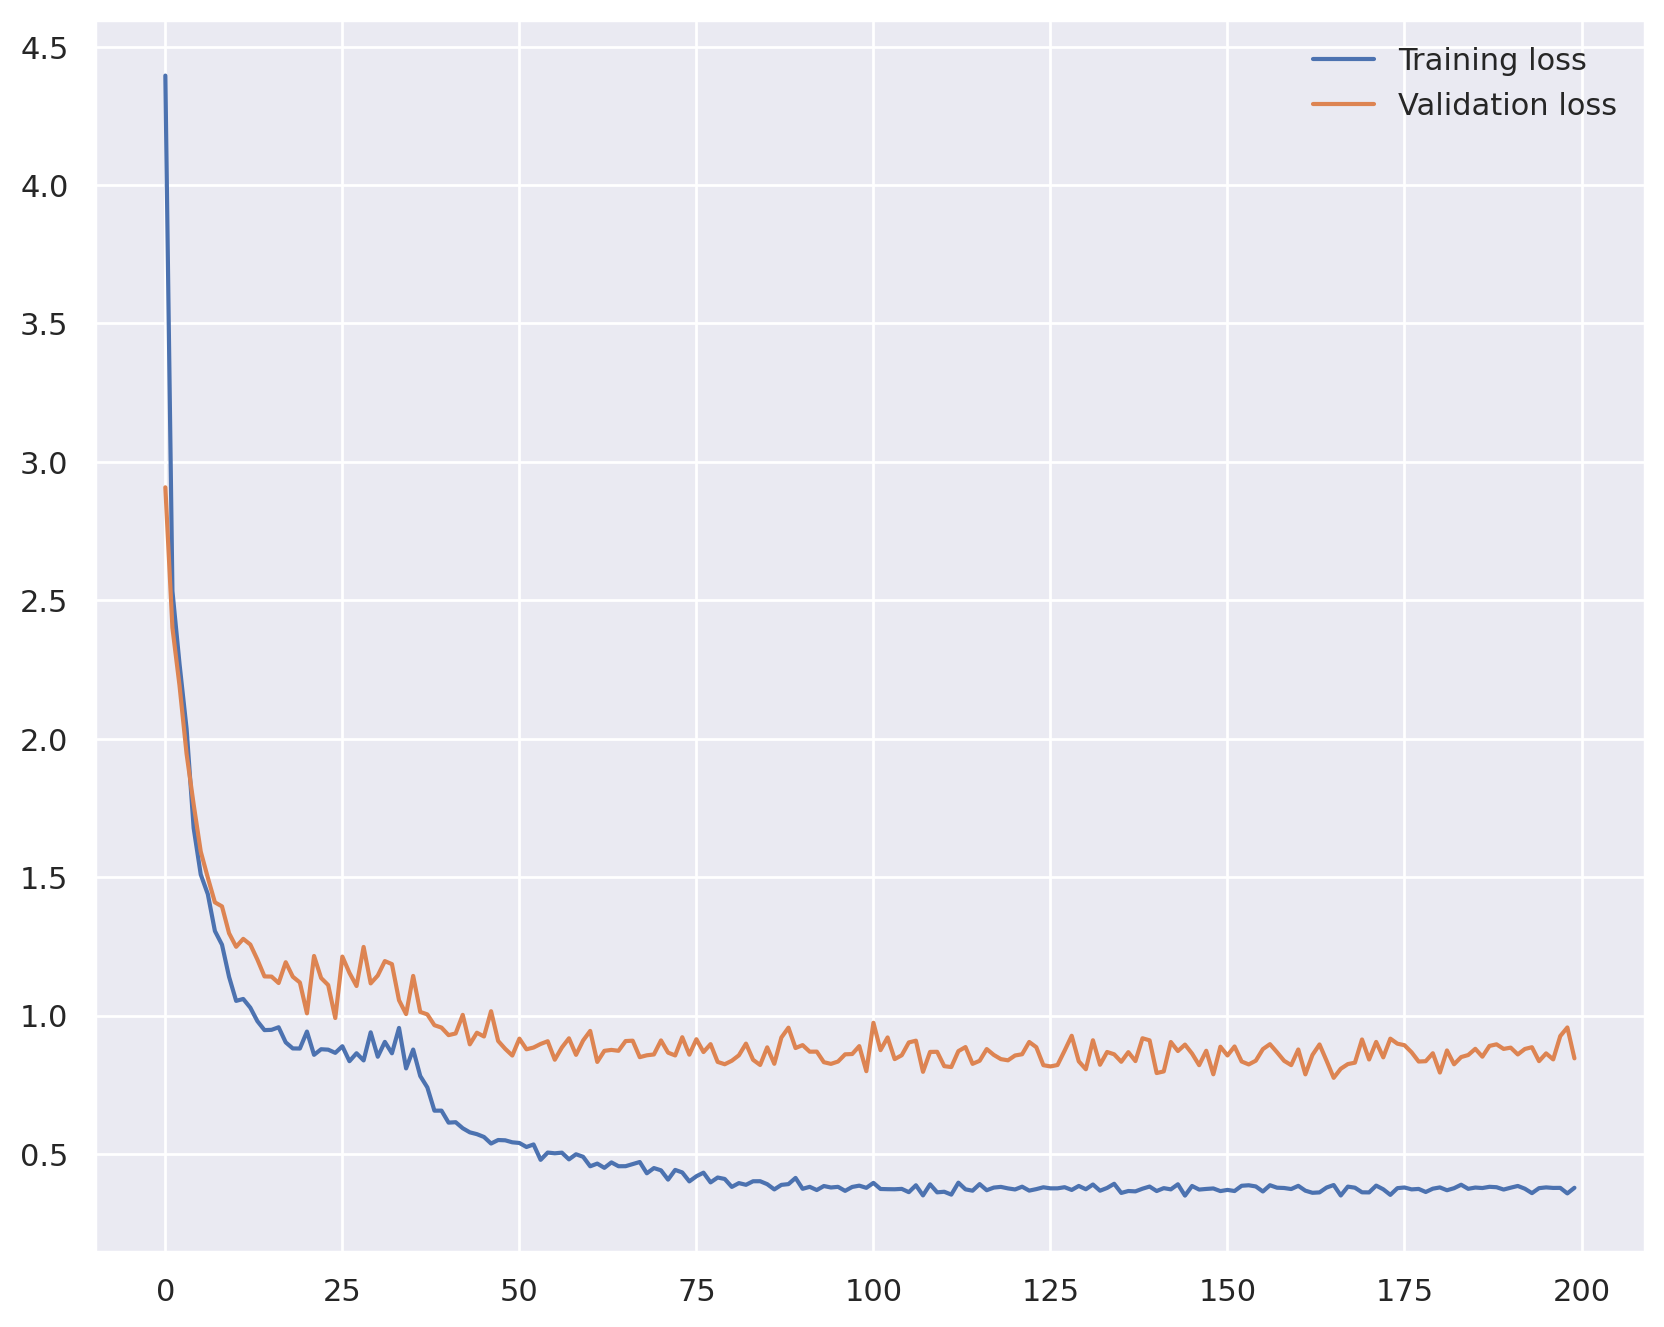

In [97]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize =(10,8))
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

### 1.3.3. Evaluation

In [98]:
model.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train = model(X_train)

y_pred_test = model(X_test)


In [99]:
y_pred_train

tensor([[6.9200],
        [8.8533],
        [7.4676],
        ...,
        [8.4629],
        [6.6340],
        [7.7457]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [100]:
# lastest
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print("Regression report")
print('R2 =',  r2_score(y_test.cpu(), y_pred_test.detach().cpu()))
print('RMSE =', mean_squared_error(y_test.cpu(), y_pred_test.detach().cpu(), squared=False))
print('MAE =', mean_absolute_error(y_test.cpu(), y_pred_test.detach().cpu()))

Regression report
R2 = 0.6796572444720986
RMSE = 0.8429696
MAE = 0.6262541


In [101]:
# best
model = Net(input_size,  dropout_rate, output_size)

checkpoint = torch.load('/content/drive/MyDrive/2. TRAINING/Data/Model/ANN_best_model.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.to(device)


model.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train = model(X_train)

y_pred_test = model(X_test)


print("Regression report")
print('R2 =',  r2_score(y_test.cpu(), y_pred_test.detach().cpu()))
print('RMSE =', mean_squared_error(y_test.cpu(), y_pred_test.detach().cpu(), squared=False))
print('MAE =', mean_absolute_error(y_test.cpu(), y_pred_test.detach().cpu()))

Regression report
R2 = 0.6796611373092002
RMSE = 0.8429645
MAE = 0.62624776
